# Esercitazione 7
### Laboratorio di Simulazione Numerica

Il materiale dell'esercitazione sette di LSN è interamente raccolto nella cartella `Lab_07/Code`. Essa contiene quattro sotto-cartelle, dai nomi `7.1, 7.2, 7.3, 7.4`, corrispondenti alle quattro consegne dell'esercizio.

Ognuna di queste cartelle contiene una copia del programma `Monte_Carlo_NVT.cpp/h` e i risultati relativi all'esecuzione dello specifico compito.

---

In questa esercitazione, per eseguire in modo più comodo i programmi, ho scritto uno script Python, che si trova nella descrizione dell'esercizio 7.1, con il quale ho reso automatici alcuni comandi da terminale. Per questa ragione, sconsiglio fortemente l'esecuzione del notebook: il processo potrebbe richiedere molto tempo.

---

La struttura del Jupyter Notebook è la seguente:
- 7.0 caricamento dei pacchetti e introduzione;
- 7.1 equilibrazione della simulazione, analisi delle funzioni di autocorrelazione e stima del numero efficace di blocchi;
- 7.2 funzione di distribuzione radiale $g(r)$;
- 7.3 aggiunta di $g(r)$ nel codice `MolDyn_NVE.cpp/h`
- 7.4 simulazione delle fasi solida, liquida e gassosa dell'Argon: stima di $g(r)$ e _banchmarking_ dei risultati ottenuti con `Monte_Carlo_NVT.cpp/h` e `MolDyn_NVE.cpp/h`.

## 7.0 - Caricamento pacchetti e introduzione

In questa esercitazione affrontiamo un problema simile a quello proposto nell'esercitazione 4, utilizzando un approccio diverso e mettendo a confronto i risultati ottenuti con i due metodi. In questo caso, le mosse (`Move()`) a cui il sistema termodinamico è sottoposto sono tipiche delle Catene di Markov, implementate sotto forma di passi estratti in modo uniforme tra zero e $\delta$ attorno al punto in cui si trova la particella. 

Questa volta, oltre a cambiare approccio, ci preoccupiamo del fenomeno dell'autoccorrelazione che è intrinsecamente presente in simulazioni in cui i dati sono ottenuti in maniera sequenziale. Nel farlo, cerchiamo di capire quale sia la dimensione più efficace dei blocchi di dati su cui effettuare le misure che contribuiscono alla stima delle grandezze tramite metodo di blocking.

In [210]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import tqdm as tqdm
from IPython.display import clear_output
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

sns.set_theme(font_scale=1.7, style='whitegrid')

## 7.1 - Equilibrazione, funzione di autocorrelazione, analisi dei blocchi

In questa prima parte dell'esercizio ho aggiunto al codice `MonteCarlo_NVT.cpp/h` il metodo `Equilibrate_system(int Nequi)`, che implementa `Nequi` mosse di metropolis che non vengono coinvolte nella stima delle grandezze (il blocking parte al termine della fase di equilibrazione). Con lo script seguente vengono eseguiti tre lanci del programma, ciascuno dei quali corrispondente ad una specifica delle tre fasi termodinamiche in analisi. Per ciascuna delle tre run ho predisposto `Nequi=10'000` passi di equilibrazione e `Nstep=50'000` passi per blocco con un totale di `Nblks=10`. In totale stiamo analizzando $5\times 10^5$ misure. 

---

Con l'intenzione di trovare un passo di metropolis tale che l'accettazione in ogni blocco sia quanto più possibile vicina al 50% ho svolto alcuni tentativi. Per gli stati solido e liquido sono riuscito a trovare un valore tale da soddisfare la richiesta. Per quanto riguarda lo stato gassoso, anche impostando come passo circa la metà del lato del box analizzato non sono riuscito ad ottenere accettazioni migliori del 62%. Le scelte definitive, con le quali ho eseguito il programma nelle celle seguenti sono:
- fase solida $\delta_s = 0.11$
- fase liquida $\delta_l = 0.2$
- fase gassosa $\delta_g = 5.0$

In [2]:
path = "Code/7.1/"
istant = []

ist_files = ["output_solid.dat", "output_liquid.dat", "output_gas.dat"]
inp_files = ["input.solid", "input.liquid", "input.gas"]
phase = ['Solido', 'Liquido', "Gas"]
colors = ['orange', 'red', 'purple']

In [47]:
print('-----------------------------------------------------')
print("Stiamo eseguendo 500'000 passi di MCMC")
print("Questo avverrà per tre volte")
print("Il processo potrebbe richiedere molto tempo.")
print("-----------------------------------------------------")

for i in range(3):
    print("Esecuzione del programma per lo stato " + phase[i])
    subprocess.call("cp " + str(inp_files[i]) + " input.dat", cwd = path, shell=True)
    subprocess.call("rm " + str(ist_files[i]), cwd = path, shell=True)
    subprocess.call("make clean", cwd = path, shell=True)
    subprocess.call("make", cwd = path, shell=True)
    subprocess.call("./Monte_Carlo_NVT.exe", cwd = path, shell=True)
    subprocess.call("cp istant_output.dat " + str(ist_files[i]), cwd = path, shell=True)
    
print("Fine dell'esecuzione!")

-----------------------------------------------------
Stiamo eseguendo 500'000 passi di MCMC
Questo avverrà per tre volte
Il processo potrebbe richiedere molto tempo.
-----------------------------------------------------
Esecuzione del programma per lo stato Solido
Esecuzione del programma per lo stato Liquido
Esecuzione del programma per lo stato Gas
Fine dell'esecuzione!


In [5]:
for i in range(3):
    istant.append(np.loadtxt(path+ist_files[i]))

In [21]:
len_ist = len(istant)

def plot_equilibration(mylist, steps, idx, title, col1, col2):
    plt.figure(figsize=(20,5))
    plt.suptitle(title)
    plt.subplot(1,2,1)
    plt.plot(mylist[idx].T[0][:steps], color=col1, linewidth=3, alpha=0.5, label='Energia')
    plt.xlabel('# passi')
    plt.ylabel('U/N')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(mylist[idx].T[2][:steps], color=col2, linewidth=3, alpha=0.5, label='Pressione')
    plt.xlabel('# passi')
    plt.ylabel('P')
    plt.legend()
    plt.tight_layout()
    
def plot_final(mylist, steps, idx, title, col1, col2):
    plt.figure(figsize=(20,5))
    plt.suptitle(title)
    plt.subplot(1,2,1)
    plt.plot(mylist[idx].T[0][-steps:], color=col1, linewidth=3, alpha=0.5, label='Energia')
    plt.xlabel('# passi')
    plt.ylabel('U/N')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(mylist[idx].T[2][-steps:], color=col2, linewidth=3, alpha=0.5, label='Pressione')
    plt.xlabel('# passi')
    plt.ylabel('P')
    plt.legend()
    plt.tight_layout()

### L'equilibrazione del sistema

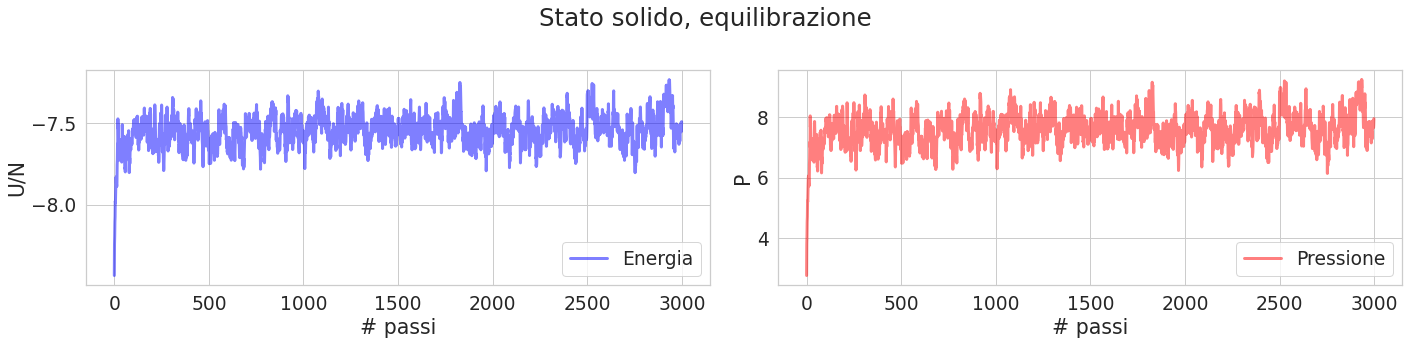

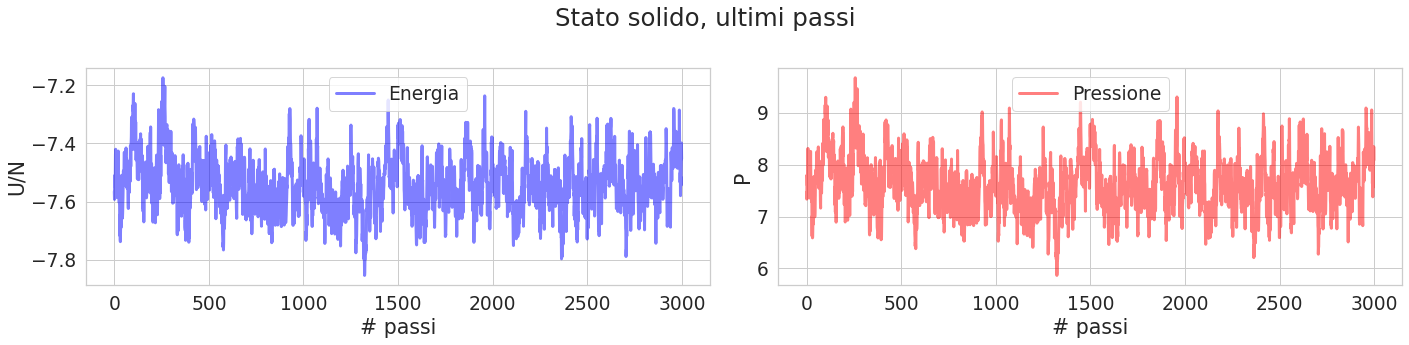

In [22]:
plot_equilibration(istant, 3000, 0, 'Stato solido, equilibrazione', 'blue', 'red')
plot_final(istant, 3000, 0, 'Stato solido, ultimi passi', 'blue', 'red')

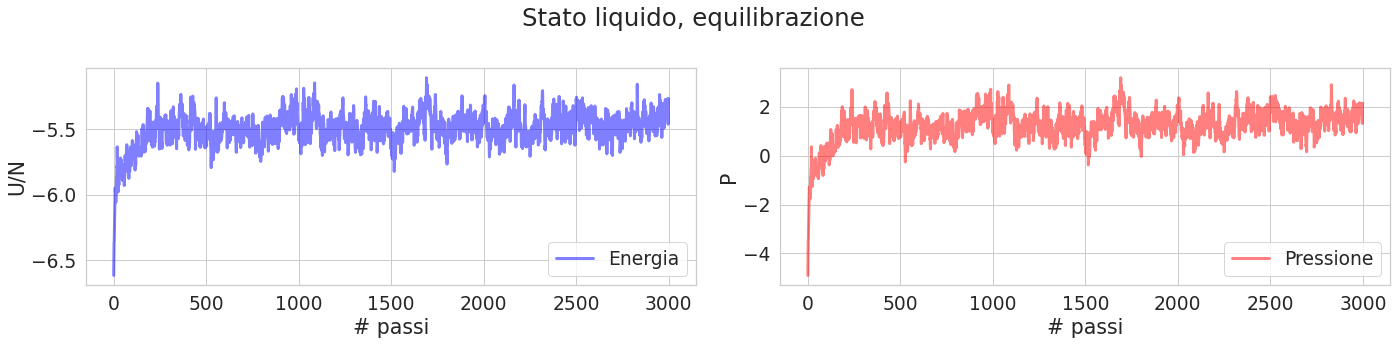

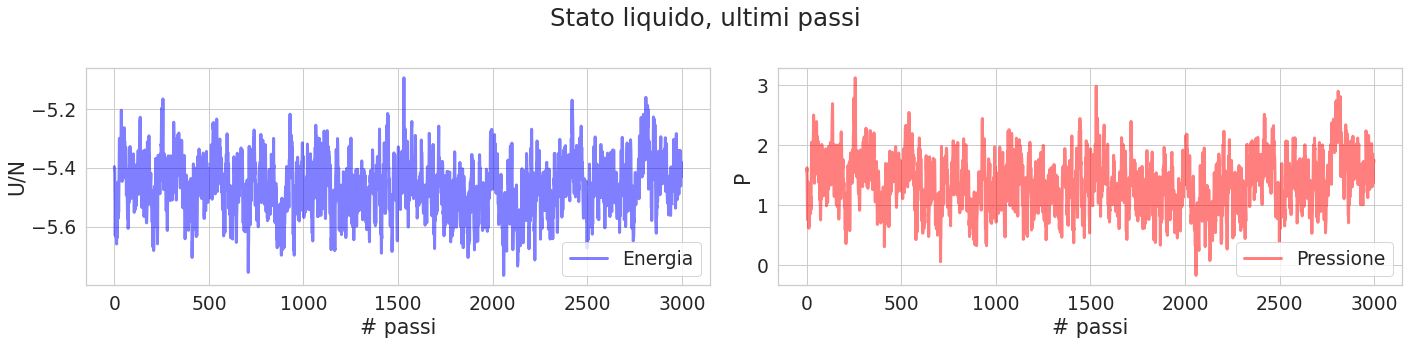

In [23]:
plot_equilibration(istant, 3000, 1, 'Stato liquido, equilibrazione', 'blue', 'red')
plot_final(istant, 3000, 1, 'Stato liquido, ultimi passi', 'blue', 'red')

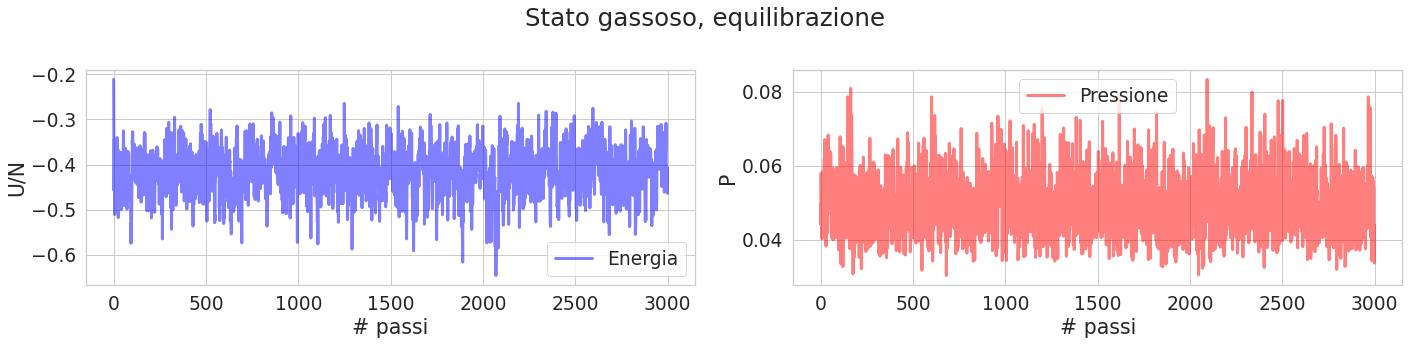

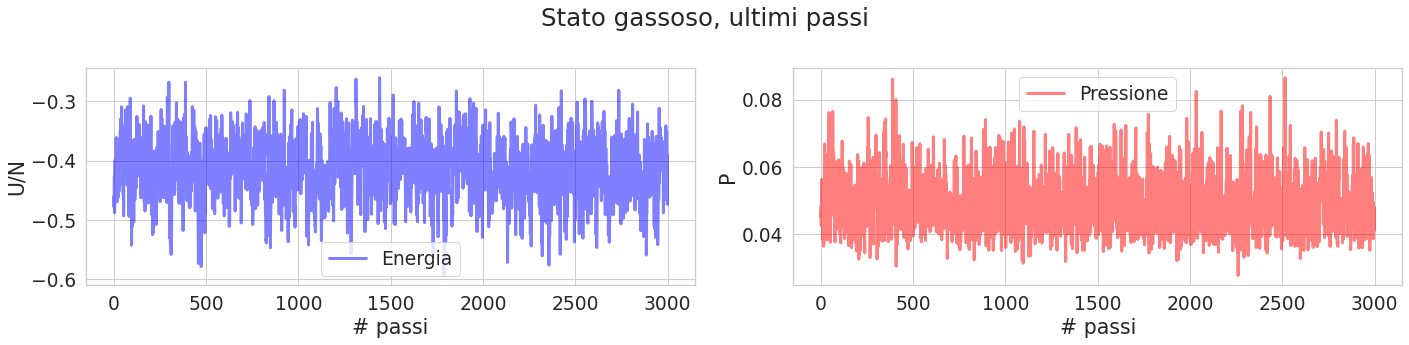

In [25]:
plot_equilibration(istant, 3000, 2, 'Stato gassoso, equilibrazione', 'blue', 'red')
plot_final(istant, 3000, 2, 'Stato gassoso, ultimi passi', 'blue', 'red')

__Figura 1:__ in figura ho rappresentato i primi e gli ultimi tremila passi delle simulazioni introdotte in precedenza. Nel caso di solido e liquido notiamo che sono necessarie poche decine di passi (meno di cinquecento) perché i valori di $U/N$ e $P$ inizino ad oscillare attorno ad un valore specifico. Nel caso del gas, invece, questo avviene sin dal primo momento. In altre parole, l'algoritmo di metropolis necessita, in questo caso, un breve processo di equilibrazione.

### La taglia dei blocchi

Vogliamo adesso comprendere quale sia il giusto numero di blocchi da scegliere per far sì che i dati tra blocchi diversi siano tra loro quanto più scorrelati possibile. Dunque calcoliamo, a partire dai dati istantanei ottenuti, il valore delle funzioni di autocorrelazione dei dati di energia potenziale e pressione le tre fasi termodinamiche di interesse. Nella cella seguente implemento la funzione di autocorrelazione come segue: 

$$ AC(\tau) = \frac{ \frac{1}{t-\tau}\sum_{t'=0}^{t-\tau}x(t')x(t'+\tau) -\frac{1}{t-\tau}\sum_{t'=0}^{t-\tau} x(t') \times \sum_{t'=0}^{t-\tau} x(t'+\tau) }{\frac{1}{\tau} \sum_{t'=0}^t x^2(t') - \biggl( \frac{1}{\tau} \sum_{t'=0}^t x(t')\biggr)^2 } $$

In pratica, il valore puntuale (a $\tau$ fissato) della funzione di autocorrelazione è dato da tutti i contributi all'autocorrelazione dovuti ai valori di pressione o energia che distano tra loro $\tau$ nelle mie liste. Prima di procedere con il calcolo elimino dalle liste le misure ottenute nel periodo di equilibrazione del sistema, che corrisponde a diecimila passi di metropolis.

---

Ho deciso di analizzare l'autocorrelazione delle misure per $\tau \in [0,500]$.

In [45]:
# voglio eliminare i punti corrispondenti all'equilibrazione

energies  = []
pressures = []

for i in range(3):
    energies.append(istant[i].T[0][10000:])     #tre liste, energie   di solido, liquido, gas
    pressures.append(istant[i].T[2][10000:])    #tre liste, pressioni di solido, liquido, gas

In [46]:
N = len(energies[1])    # 500'000

La cella seguente viene eseguita in un tempo $t\sim 16$ min, come è possibile leggere a fianco delle barre di caricamento stampate tramite il metodo `tqdm.tqdm` dell'omonima libreria.

In [47]:
AC_U = []
AC_P = []


npoints = 500

for i in range(3):
    print("Funzione di autocorrelazione, fase " + phase[i])
    ac_u = []
    ac_p = []
    # ciclo su tutte le taglie tau
    for tau in tqdm.tqdm(range(npoints)):
        U_minus_tau = energies[i][:N - tau]       # taglio gli ultimi tau valori
        P_minus_tau = pressures[i][:N - tau]
        U_plus_tau = energies[i][tau:]            # taglio i primi tau valori
        P_plus_tau = pressures[i][tau:]
        
        # in questo modo, moltiplicando U_minus_tau[i]*U_plus_tau[i] sto eseguendo il prodotto di due elementi
        # che si trovano distanziati esattamente di tau (con tau che varia nel corso dei 500 loop del ciclo for)

        n = len(U_minus_tau)                      # corrisponde al nostro t-tau = 500'000 - tau
        
        ac_u.append((sum(U_minus_tau * U_plus_tau)/n - sum(U_minus_tau) / n * sum(U_plus_tau) / n)   #numeratore
                    / np.std(energies[i])**2)                                                        #varianza
        ac_p.append((sum(P_minus_tau * P_plus_tau)/n - sum(P_minus_tau) / n * sum(P_plus_tau) / n)
                    / np.std(pressures[i])**2)
        
    # ancora una volta tre liste, una per fase 
    AC_U.append(ac_u)
    AC_P.append(ac_p)


  0%|                                                                       | 0/500 [00:00<?, ?it/s]

Funzione di autocorrelazione, fase Solido


  0%|                                                                       | 0/500 [00:00<?, ?it/s]

Funzione di autocorrelazione, fase Liquido


  0%|                                                                       | 0/500 [00:00<?, ?it/s]

Funzione di autocorrelazione, fase Gas


100%|█████████████████████████████████████████████████████████████| 500/500 [05:27<00:00,  1.53it/s]


In [85]:
def plot_ac(idx, cut1, cut2, col1, col2, title):
    plt.figure(figsize=(18,6))
    plt.suptitle(title)
    
    plt.subplot(1,2,1)
    plt.plot(AC_U[idx], linewidth=3, color=col1, alpha=0.6, label='U/N')
    plt.plot(AC_P[idx], linewidth=3, color=col2, alpha=0.6, label='P')
    plt.axvspan(0, cut1, facecolor='black', alpha=0.15, label=r'Regione dei $\tau$ da escludere')
    plt.xlabel(r'$\tau$')
    plt.ylabel(r'$AC(\tau)$')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(AC_U[idx][cut1:], linewidth=3, color=col1, alpha=0.6, label='U/N')
    plt.plot(AC_P[idx][cut2:], linewidth=3, color=col2, alpha=0.6, label='P')
    plt.xlabel(r'$\tau$')
    plt.ylabel(r'$AC(\tau)$')
    plt.legend()
    plt.tight_layout()

    plt.show()

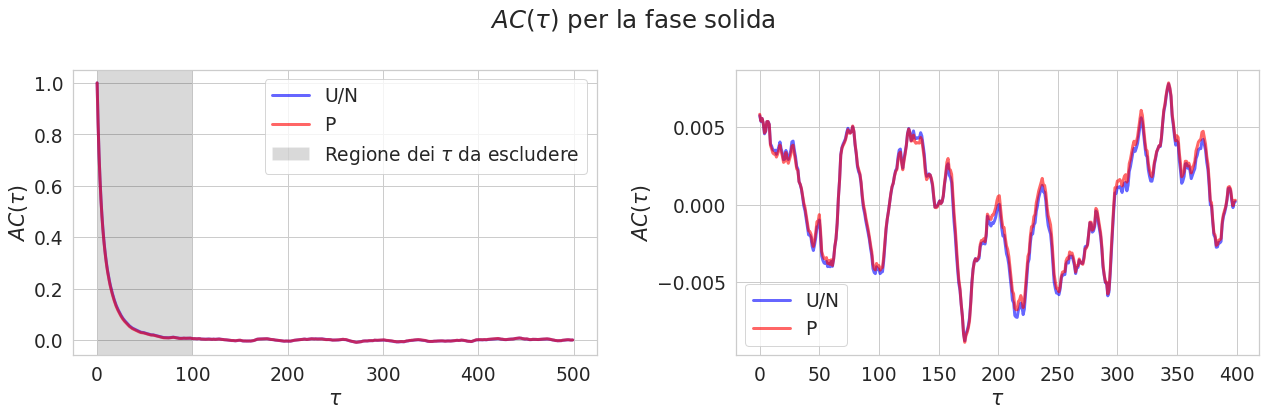

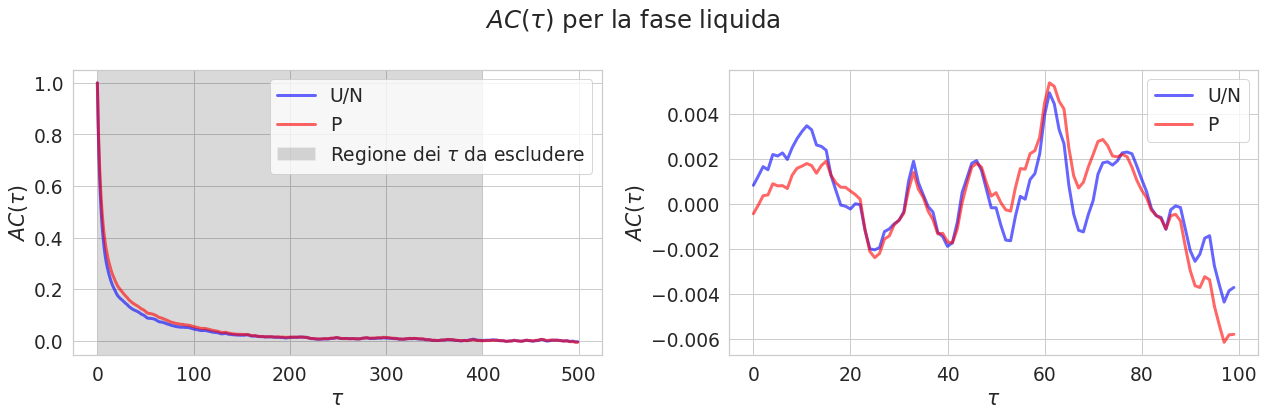

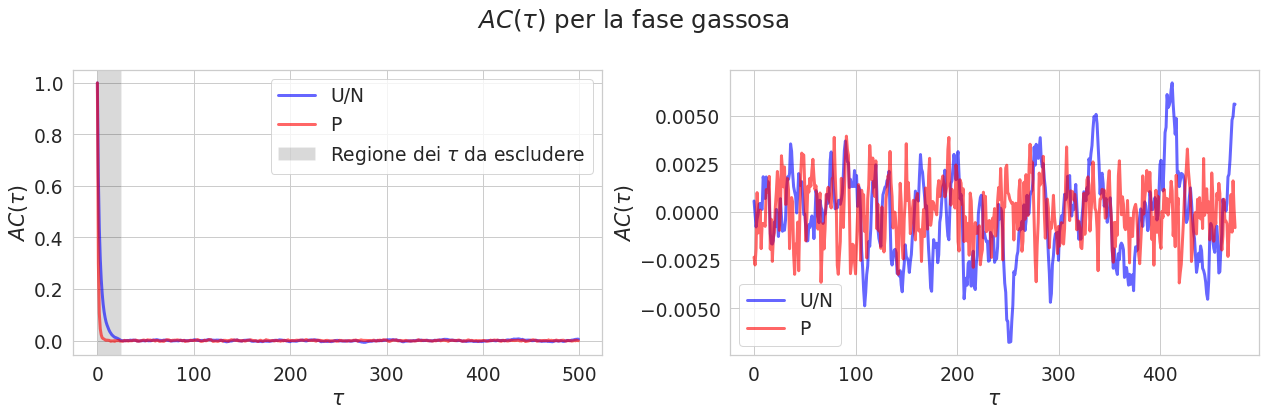

In [95]:
plot_ac(0, 100, 100, 'blue', 'red', r'$AC(\tau)$ per la fase solida')
plot_ac(1, 400, 400, 'blue', 'red', r'$AC(\tau)$ per la fase liquida')
plot_ac(2, 25, 25, 'blue', 'red', r'$AC(\tau)$ per la fase gassosa')

__Figura 2:__ dal basso verso l'alto, andamento del valore dell'autocorrelazione delle misure di $U/N$ e di $P$ in funzione di $\tau$ per gli stati solido, liquido e gassoso. Nelle immagini a sinistra, andamendo di $AC(\tau)$ su tutto il dominio dei $\tau$ analizzato. A destra, andamento della stessa funzione avendo escluso la porzione di intervallo in cui $AC(\tau)$ è apprezzabilmente maggiore di zero. Lo stato che sembra "liberarsi" più rapidamente dell'autocorrelazione tra i dati è il gas. Nel caso del gas, infatti, la curva rappresentativa del valore dell'autocorrelazione raggiunge un valore prossimo allo zero per $\tau>25$. Analizzando il comportamento di $AC(\tau)$ per la fase solida, possiamo assumere raggiunta una condizione di scorrelazione tra i dati per tagli di dimensione $\tau>100$. Oltre tale valore, infatti, la funzione inizia ad oscillare in modo contenuto attorno allo zero. Lo stato che conserva per più tempo la memoria statistica del sistema è quello liquido, infatti, in entrambi i casi di $U/N$ e $P$ vediamo che la $AC(\tau)$ rimane apprezzabilmente sopra lo zero fino a taglie $\tau > 400$. Queste considerazioni servono a stabilire che i blocchi di dati con cui effettuiamo le misure (per esempio tramite il metodo _blocking_) devono avere dimensioni ben superiori ai numeri che ho citato. Infatti, sebbene possiamo considerare scorrelati due dati che si trovano ad una distanza maggiore di $\tau_m$ in una sequenza, per poter affermare che una misura sul blocco è ricavata tramite dati scorrelati da quelli utilizzati in un altro blocco è necessario confinare questi effetti di correlazione ai bordi dei blocchi. Se, per esempio, consideriamo il caso del liquido, avendo stabilito che $400$ è il passo minimo per ritenere scorrelati due elementi, allora abbiamo necessità di ricavare dei blocchi di dimensione ben superiore a $400$, così che eventuale memoria statistica rimanga vincolata ai soli bordi del blocco di dati utilizzato.

Sempre nell'ottica di andare a stabilire la taglia ottimale dei blocchi, procediamo in direzione opposta: una volta capito che un blocco non deve contenere __meno__ di $\tau_m$ dati, andiamo a controllare fino a che valore $\tau_M>\tau_m$ è conveniente spingersi in termini di precisione statistica. In altre parole, oltre che valore $\tau_M$ è inutile allargare il blocco perché ci troveremmo a spendere tempo computazionale senza ottenere un guadagno in termini di precisione? 

In [96]:
# implementiamo il metodo blocking

def error(AV,AV2,n):  
    if n==0:
        return 0
    else:
        return np.sqrt((AV2[n] - AV[n]**2)/n)

def blocking(r,L):   
    
    M = len(r)
    N=int(M/L)
    x = np.arange(N)
    ave = np.zeros(N)
    av2 = np.zeros(N)
    sum_prog = np.zeros(N)
    su2_prog = np.zeros(N)
    err_prog = np.zeros(N)

    for i in range(N):
        sum = 0
        for j in range(L):
            k = j+i*L
            sum += r[k]
        ave[i] = sum/L       # r_i 
        av2[i] = (ave[i])**2 # (r_i)^2 

    for i in range(N):
        for j in range(i+1):
            sum_prog[i] += ave[j] # SUM_{j=0,i} r_j
            su2_prog[i] += av2[j] # SUM_{j=0,i} (r_j)^2
        sum_prog[i]/=(i+1) # Cumulative average
        su2_prog[i]/=(i+1) # Cumulative square average
        err_prog[i] = error(sum_prog,su2_prog,i) # Statistical uncertainty
        
    return err_prog[len(err_prog)-1]  #stampo l'ultimo errore del blocking poichè restituisce un vettorone

In [109]:
L = np.arange(10, 5000, 20)       # da L=10 a L=5000 a passi di 20

La cella seguente impiega molto tempo di calcolo, sconsiglio di eseguirla.

In [252]:
%%time

ERR_U = []
ERR_P = []

for iphase in range(3): 

    print("Calcolo dell'errore sull'ultimo blocco nel range L:[10,5000] per lo stato " + phase[iphase])
    err_u = []
    err_p = []
    for i in tqdm.tqdm(range(len(L))):
        err_u.append(blocking(energies[iphase] , L[i]))
        err_p.append(blocking(pressures[iphase], L[i]))
    
    ERR_U.append(err_u)
    ERR_P.append(err_p)

  0%|                                                                       | 0/250 [00:00<?, ?it/s]

Calcolo dell'errore sull'ultimo blocco nel range L:[10,5000] per lo stato Solido


  0%|                                                                       | 0/250 [00:00<?, ?it/s]

Calcolo dell'errore sull'ultimo blocco nel range L:[10,5000] per lo stato Liquido


  0%|                                                                       | 0/250 [00:00<?, ?it/s]

Calcolo dell'errore sull'ultimo blocco nel range L:[10,5000] per lo stato Gas


100%|█████████████████████████████████████████████████████████████| 250/250 [57:03<00:00, 13.70s/it]

CPU times: user 2h 50min 59s, sys: 1.14 s, total: 2h 51min 1s
Wall time: 2h 51min 3s


In [253]:
sns.set_theme(font_scale=1.7, style='whitegrid')

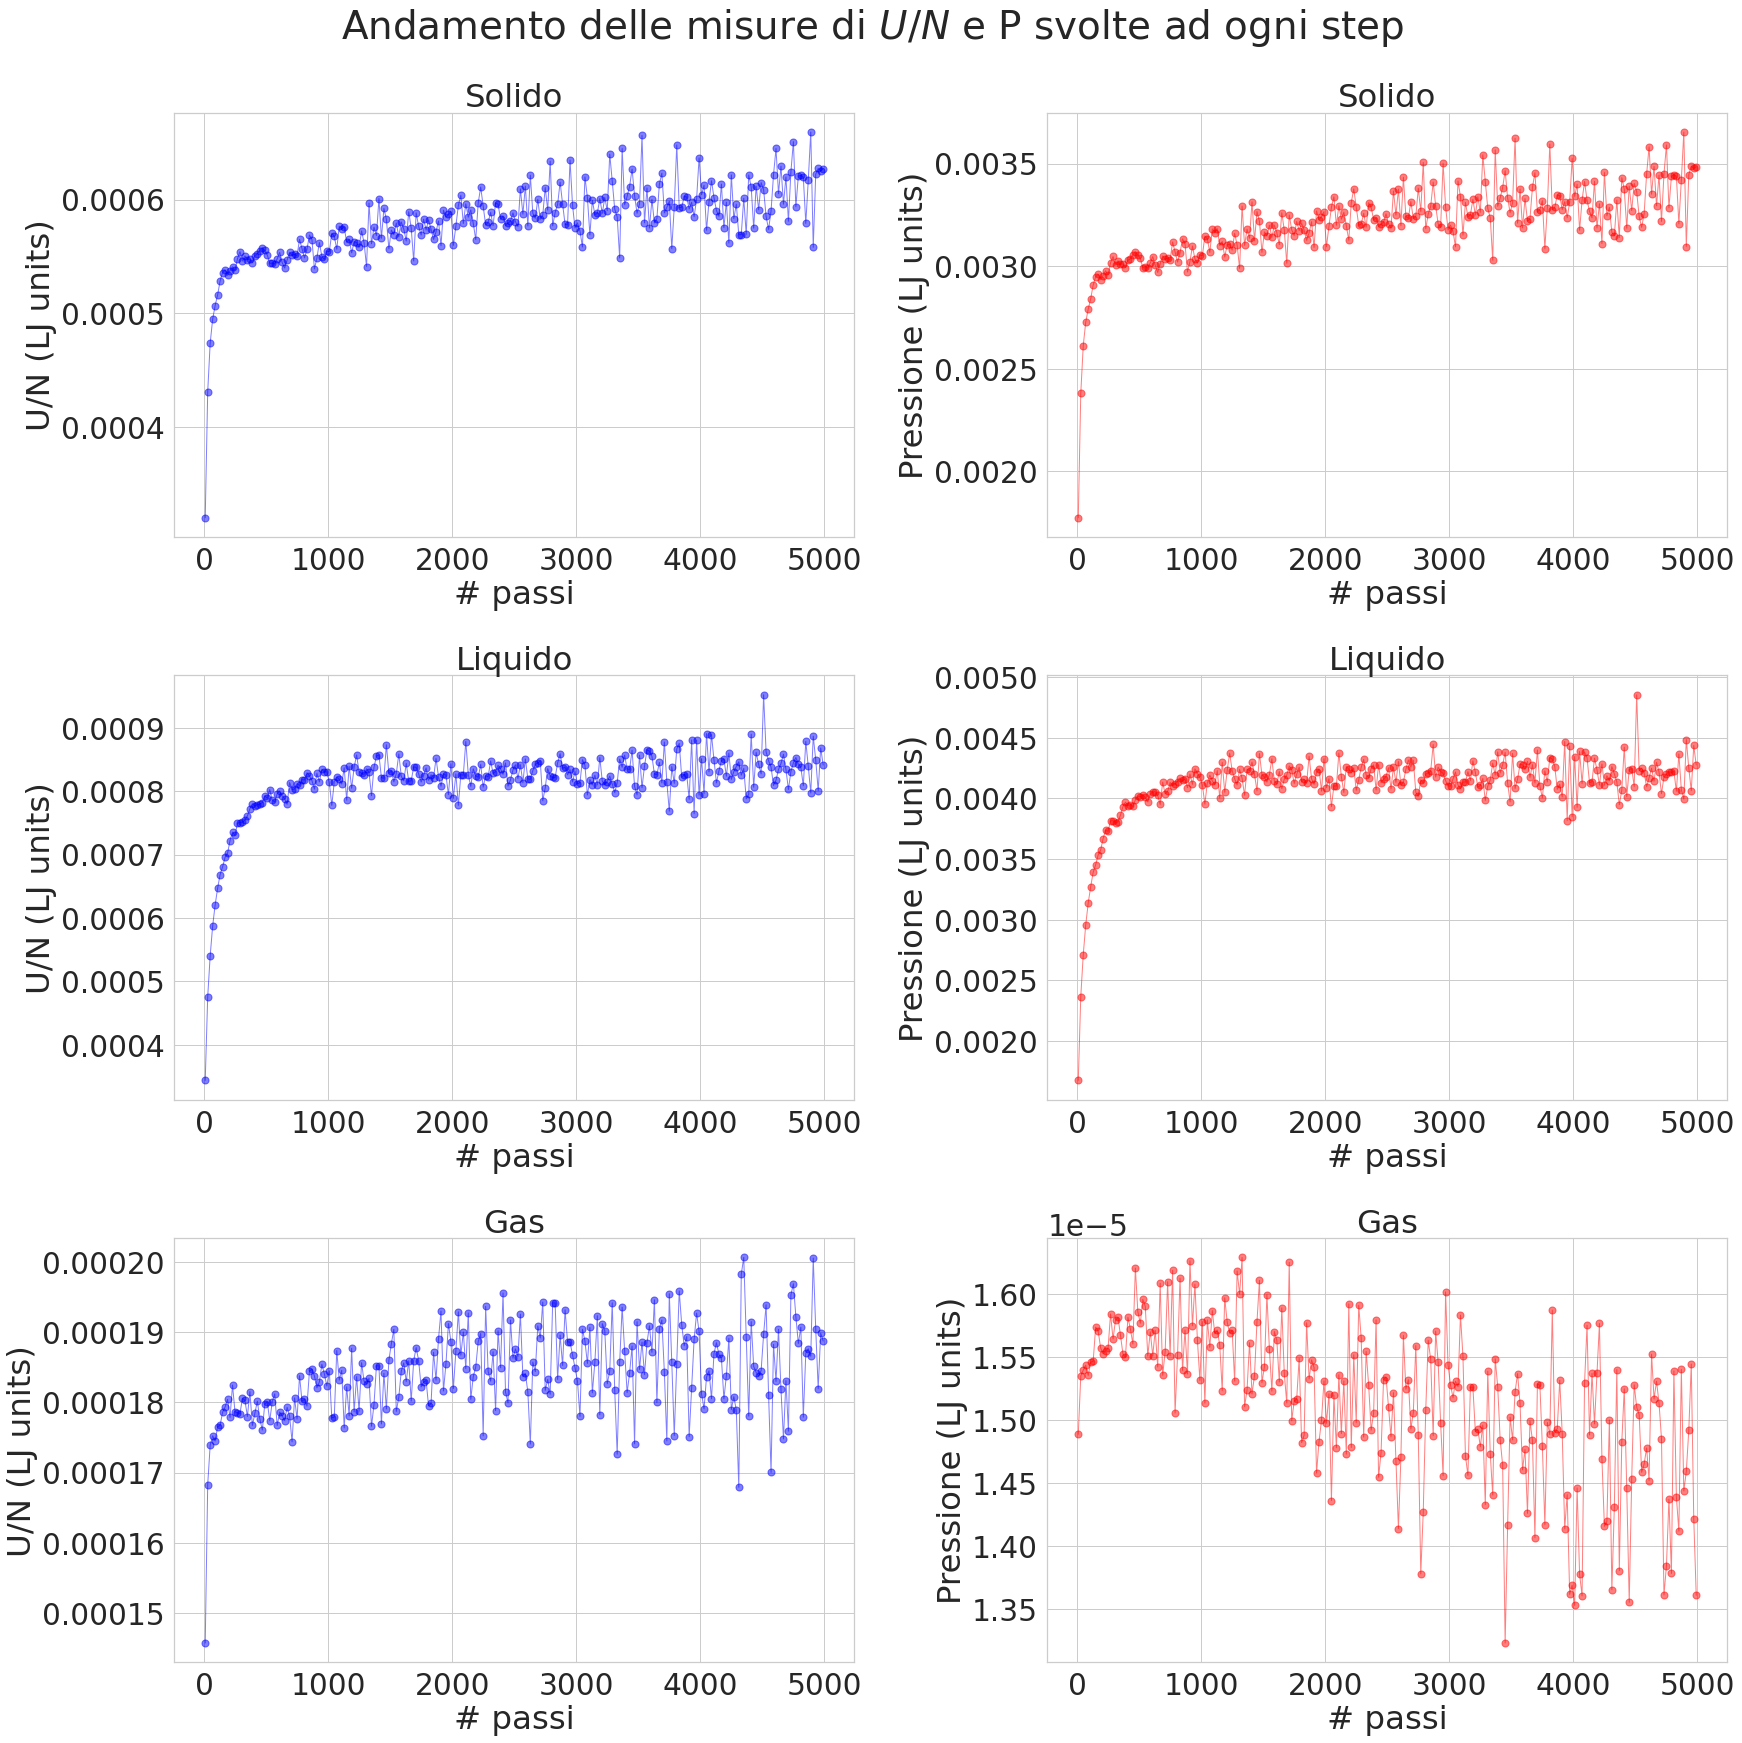

In [254]:
plt.figure(figsize=(25,25))
sns.set_theme(font_scale=2.7, style='whitegrid')

plt.suptitle('Andamento delle misure di $U/N$ e P svolte ad ogni step')

for i in range(0,6,2):
    
    plt.subplot(3,2,i+1)
    plt.title(phase[int(i/2)])
    plt.scatter(L, ERR_U[int(i/2)], s=50, alpha=0.5, color='blue')
    plt.plot(L, ERR_U[int(i/2)], linewidth=1, alpha=0.5, color='blue')
    plt.xlabel('# passi')
    plt.ylabel('U/N (LJ units)')
    
    plt.subplot(3,2,i+2)
    plt.title(phase[int(i/2)])
    plt.scatter(L, ERR_P[int(i/2)], s=50, alpha=0.5, color='red')
    plt.plot(L, ERR_P[int(i/2)], linewidth=1, alpha=0.5, color='red')
    plt.xlabel('# passi')
    plt.ylabel('Pressione (LJ units)')

plt.tight_layout()    
plt.show()

__Figura :__ in questa figura ho stampato l'errore finale ottenuto stimando pressione ed energia interna media per sito tramite il metodo delle medie a blocchi in funzione del numero di passi contenuti in ciascun blocco. L'idea è quella di capire oltre che taglia non ha senso spingersi in termini di guadagno statistico. Notiamo che nel caso dello stato solido viene raggiunta una condizione ottimale molto presto: in tal caso non avrebbe senso costruire blocchi di dimensione maggiore ai mille elementi. Nel caso del gas e soprattutto del liquido invece ha senso stabilire delle taglie maggiori, corrispondenti a valori $\tau>2000$. 

Per essere certo di confinare i fenomeni di autocorrelazione sul bordo ed volendo al contempo costruire dei blocchi di taglia utile ho deciso di eseguire le simulazioni seguenti adottando $L_{solid} = L_{gas} = 3000$ e $L_{liquid}= 8000$.



## 7.2 - 7.3 - 7.4 - Stima della $g(r)$ nelle tre fasi e utilizzando due approcci diversi

Introduciamo ora $g(r)$, funzione di _distrubuzione delle coppie radiale_, che esprime la probabilità di trovare due particelle ad una precisa distanza reciproca $r$. Si tratta dunque di una funzione di conteggio che deve essere opportunamente normalizzata tenendo conto del tipo di sistema che si sta analizzando. Nel nostro caso, effettuiamo un vero e proprio conteggio: 
1. definiamo il _range_ di raggi di interesse $r\in[0,\text{box}]$ (tramite i valori iniziali di densità e numero di particelle si calcola il volume e, di conseguenza, una stima del raggio);
2. dividiamo questo intervallo in $N_{bin}$ segmenti;
3. ad ogni passo della simulazione contiamo quante particelle si trovano ad una distanza $r\in \text{bin}[x_i, x_{i+1}]$ e, per ogni coppia trovata, aggiungiamo due unità al parziale relativo a quel bin;
4. terminato il processo per tutte le particelle normalizziamo i valori ottenuti in ciascun bin utilizzando la quantità: $$ \rho N \Delta V(r),\qquad \text{dove} \qquad \Delta V(r) = \frac{4\pi}{3} \bigl[(r+dr)^3-r^3 \bigr].$$

In questo modo otteniamo $N_{bin}$ misure, ciascuna corrispondente al valore che $g(r)$ assume per il sistema in esame alla distanza $r$, che è approssimata dai segmenti corrispondenti ai bin. Come in tutti i casi in cui ci proponiamo di stimare una grandezza, anche in questo utilizziamo il metodo delle medie a blocchi per stimare i valori di $g(r)$.

---

Questo approccio è utilizzabile all'interno del codice costruito per questa esercitazione ma anche nel caso dell'algoritmo di dinamica molecolare implementato per lo svolgimento dell'esercitazione quattro. Nel codice `MolDyn_NVE.cpp/h` avevo scritto un metodo `blocking` che opera in modo indipendente sulle singole componenti di un vettore `measure`. Per adattare il problema alla misura della $g(r)$ ho dunque aumentato la dimensione delle variabili da misurare da quattro a $4+N_{bin}$. In questo modo, ho eseguito altrettante operazioni indipendenti di media a blocchi, sfruttando la struttura dinamica del metodo.

---

#### Simulazioni stato solido

|Parametro|NVE|NVT|
|---|---|---|
|`L`|  | `3000` |
| `Nblks` | `100` | `20`|

#### Simulazioni stato liquido

|Parametro|NVE|NVT|
|---|---|---|
|`L`|  | `8000` |
| `Nblks` | `100` | `20`|

#### Simulazioni stato gassoso

|Parametro|NVE|NVT|
|---|---|---|
|`L`|  | `3000` |
| `Nblks` | `100` | `20`|

In [236]:
gofr_solid  = np.loadtxt('Results/gofr_NVT_solid.0')
gofr_liquid = np.loadtxt('Results/gofr_NVT_liquid.0')
gofr_gas    = np.loadtxt('Results/gofr_NVT_gas.0')

In [237]:
NVE_solid = np.loadtxt("Results/gofr_NVE_solid.dat")
NVE_liquid = np.loadtxt("Results/gofr_NVE_liquid.dat")

NVE_gas_5000 = np.loadtxt("Results/gofr_NVE_gas_5000.dat")
NVE_gas_10000 = np.loadtxt("Results/gofr_NVE_gas_10000.dat")
NVE_gas_30000 = np.loadtxt("Results/gofr_NVE_gas_30000.dat")
NVE_gas_50000 = np.loadtxt("Results/gofr_NVE_gas_50000.dat")

In [238]:
hist_vals_sol = []
hist_errs_sol = []
hist_vals_liq = []
hist_errs_liq = []
hist_vals_gas_05k = []
hist_errs_gas_05k = []
hist_vals_gas_10k = []
hist_errs_gas_10k = []
hist_vals_gas_30k = []
hist_errs_gas_30k = []
hist_vals_gas_50k = []
hist_errs_gas_50k = []

nbins = 100
nprop = 4
binsize = ()

r_liq = gofr_liquid.T[0]
r_sol = gofr_solid.T[0]
r_gas = gofr_gas.T[0]

for i in range(8,int(2*(nbins+nprop)),2):
    hist_vals_sol.append(NVE_solid.T[i][9])
    hist_errs_sol.append(NVE_solid.T[i+1][9])
    hist_vals_liq.append(NVE_liquid.T[i][9])
    hist_errs_liq.append(NVE_liquid.T[i+1][9])
    hist_vals_gas_05k.append(NVE_gas_5000.T[i][59])
    hist_errs_gas_05k.append(NVE_gas_5000.T[i+1][59])
    hist_vals_gas_10k.append(NVE_gas_10000.T[i][59])
    hist_errs_gas_10k.append(NVE_gas_10000.T[i+1][59])
    hist_vals_gas_30k.append(NVE_gas_30000.T[i][59])
    hist_errs_gas_30k.append(NVE_gas_30000.T[i+1][59])
    hist_vals_gas_50k.append(NVE_gas_50000.T[i][99])
    hist_errs_gas_50k.append(NVE_gas_50000.T[i+1][99])
    
len(r_sol)
len(gofr_solid.T[2])

100

In [232]:
def plot_gofr(r, gofr_NVT, gofr_NVE, err_NVT, err_NVE, title, col1, col2, lab_NVT, lab_NVE,_x1, _x2, _y1, _y2):
    fig, ax = plt.subplots(figsize=[20, 8])
    plt.title(title)
    plt.xlabel('r')
    plt.ylabel('g(r)')
    
    axins=zoomed_inset_axes(ax,4,loc=2)   
    x1, x2, y1, y2 = _x1, _x2, _y1, _y2
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    plt.xticks(visible=False)
    plt.yticks(visible=False)
    
    ax.errorbar(r, gofr_NVE, yerr=err_NVE, color=col2, linewidth=2, alpha=0.5, label=lab_NVE)
    ax.errorbar(r, gofr_NVT, yerr=err_NVT, color=col1, linewidth=2, alpha=0.5, label=lab_NVT)
    axins.errorbar(r, gofr_NVE, yerr=err_NVE, color=col2, linewidth=2, alpha=0.5, label=lab_NVE)
    axins.errorbar(r, gofr_NVT, yerr=err_NVT, color=col1, linewidth=2, alpha=0.5, label=lab_NVT)
    ax.legend()
    mark_inset(ax,axins,loc1=1,loc2=2,fc='none',ec='0.5')

plt.tight_layout()    
plt.show()

<Figure size 432x288 with 0 Axes>

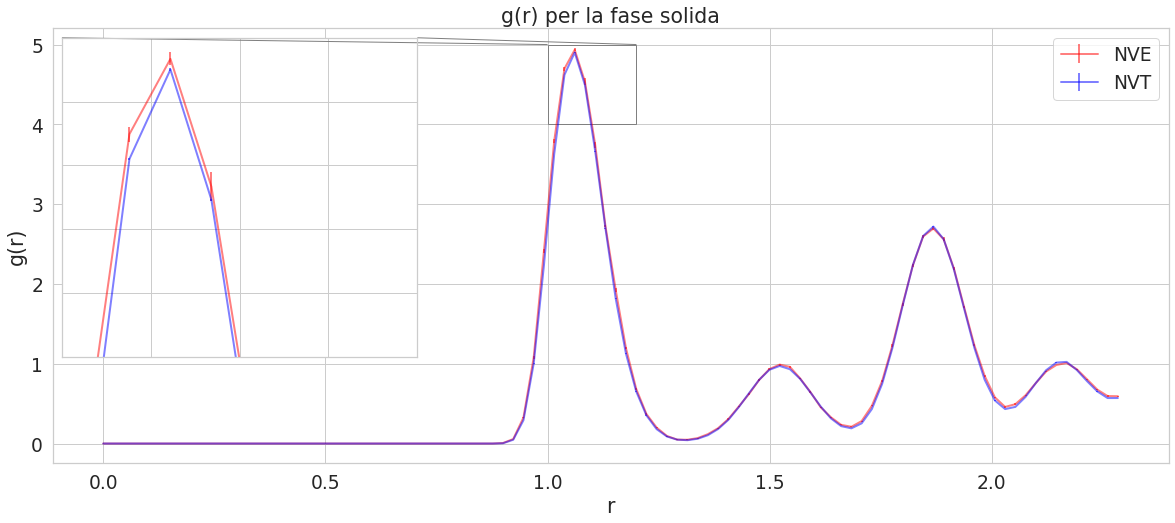

In [233]:
plot_gofr(r_sol, gofr_solid.T[1], hist_vals_sol, gofr_solid.T[2], hist_errs_sol, 
         'g(r) per la fase solida', 'blue', 'red', 'NVT', 'NVE', 1, 1.2, 4, 5)

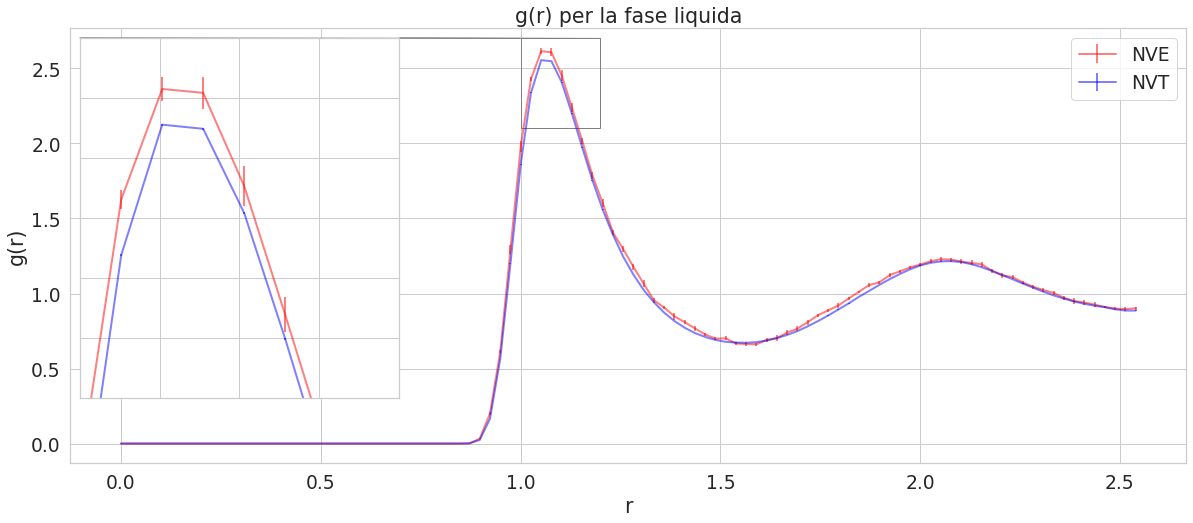

In [248]:
plot_gofr(r_liq, gofr_liquid.T[1], hist_vals_liq, gofr_liquid.T[2], hist_errs_liq, 
         'g(r) per la fase liquida', 'blue', 'red', 'NVT', 'NVE', 1, 1.2, 2.1, 2.7)

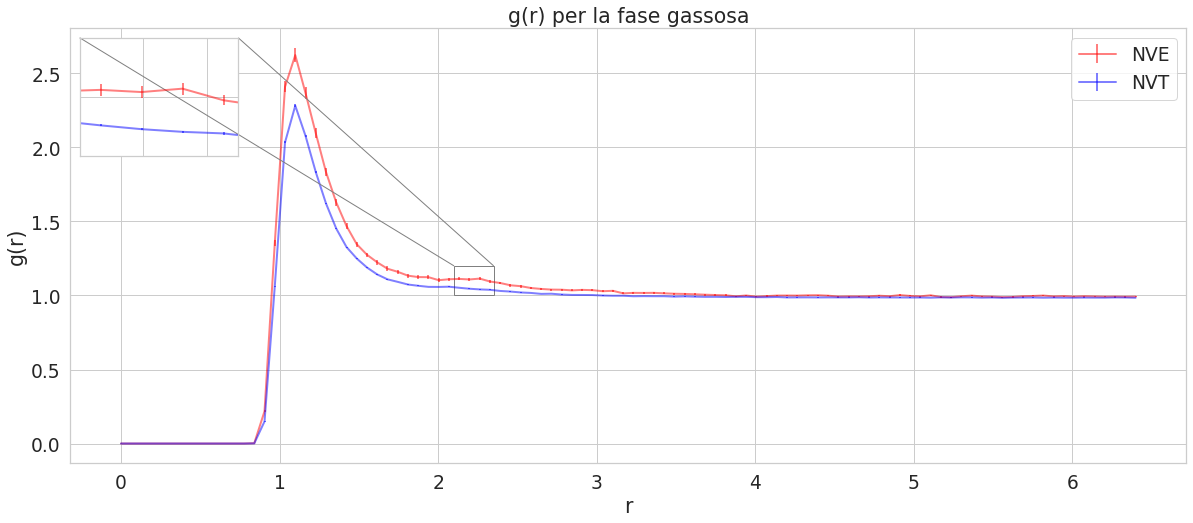

In [250]:
plot_gofr(r_gas, gofr_gas.T[1], hist_vals_gas_05k, gofr_gas.T[2], hist_errs_gas_05k, 
         'g(r) per la fase gassosa', 'blue', 'red', 'NVT', 'NVE', 2.1, 2.35, 1, 1.2)